### TP 2 : 

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

Question 1 : **Non-homogeneous Poisson process and trade times**. Implement a thinning algorithm 
for the simulation of a non-homogeneous Poisson process on $[0,T]$ with a given intensity
$\mu : [0,T] \rightarrow \mathbb{R}^+$. Make some tests to check that your simulation 
algorithm is correct. 
Propose/calibrate a deterministic intensity function $f$ that represents the intensity of
occurrence of trades during a trading day. Using simulations of a (non-homogeneous)
Poisson process with intensity $f$, comment on the statistical properties of the fitted model
and on the goodness-of-fit of this model.

In [ ]:
import numpy 
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
import tqdm   
import Hawkes as hwk

In [ ]:
def simulate_nonhomogeneous_poisson(T, mu, mu_max=None):

    if mu_max is None:
        mu_max = 1.1 * max(mu(numpy.linspace(0, T, 1000)))
    events = []
    t = 0
    
    while t < T:
        t += numpy.random.exponential(1 / mu_max)
        if t >= T:
            break
        
        if numpy.random.uniform(0, 1) < mu(t) / mu_max:
            events.append(t)
    
    return numpy.array(events)


def mu(t):
    return 5 * (1 + numpy.sin(2 * numpy.pi * t))  

def mu2(t):
    return 5 * (1 + numpy.cos(numpy.pi * t * 0.2))

T = 10     
mu_max = 10  

events = simulate_nonhomogeneous_poisson(T, mu, mu_max)
events2 = simulate_nonhomogeneous_poisson(T, mu2, mu_max)

def plot(events, mu, mu_max, num_intervals = 10):
    
    if len(events) < 10 * events[-1] : 
        plt.figure(figsize=(10, 5))
        plt.vlines(events, ymin=0, ymax=1, color='b', label='Simulated Events')
        times = numpy.linspace(0, T, 1000)
        plt.plot(times, mu(times) / mu_max, 'r', label=r'$\mu(t) / \mu_{max}$')
        plt.xlabel('Time')
        plt.ylabel('Normalized Intensity & Events')
        plt.title('Simulation of a Non-Homogeneous Poisson Process')
        plt.legend()
        plt.show()

    intervals = numpy.linspace(0, T, num_intervals+1)
    empirical_counts = [numpy.sum((events >= intervals[i]) & (events < intervals[i+1])) for i in range(num_intervals)]
    expected_counts = [numpy.trapz(mu(numpy.linspace(intervals[i], intervals[i+1], 100)), numpy.linspace(intervals[i], intervals[i+1], 100)) for i in range(num_intervals)]
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_intervals), empirical_counts, alpha=0.6, label='Empirical Counts', width=1.0)
    plt.plot(range(num_intervals), expected_counts, 'r-', label='Expected Counts', linewidth=2, alpha = 0.5)
    plt.xlabel('Time Interval')
    plt.ylabel('Number of Events')
    plt.legend()
    plt.title('Empirical vs. Expected Event Counts')
    plt.show()
plot(events, mu, mu_max)
plot(events2, mu2, mu_max)

Those graphs represent the chosen intensity for the Poisson process and 
the simulated event times and then the expected number of events per intervals 
along with the empirical count of events in our simulated data for two examples 
of intensity functions. We can see that the empirical count roughly follows the 
expected counts and the time between 2 events is shorter when the intensity is high.

In [ ]:
def plot_event_density(df, title):
    df['minutes'] = df['ets'].dt.hour*60 + df['ets'].dt.minute + df['ets'].dt.second / 60.0
    
    plt.figure(figsize=(10, 5))
    plt.hist(df['minutes'], bins=24*60, density=True, alpha=0.6, color='b', edgecolor='black')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Density')
    plt.title('Intensity of occurence of trades throughout the day for day ' + title[3:11])
    plt.show()

In [ ]:
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    # "SG_20170120.csv.gz", # Different from the others days (spike of activity)
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
]

file_test = "SG_20170201.csv.gz"

for file in file_list:
    
    df = pd.read_csv(f'./TP/High-Frequency-Data-Limit-Order-Books/Data/SG/{file}')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df = df.loc[df['etype']=='T']
    plot_event_density(df, file)

df_test = pd.read_csv(f'./TP/High-Frequency-Data-Limit-Order-Books/Data/SG/{file_test}')
df_test.drop(df_test.columns[0], axis=1, inplace=True)
df_test['ets'] = pd.to_datetime(df_test['ets'], format="%Y%m%d:%H:%M:%S.%f")
df_test = df_test.loc[df_test['etype']=='T']

Those plots represent the density of events throughout the day for each 
day in the dataset. We can see that the intensity of events is greater 
at the opening and the close. We will try to reproduce this density 
with our simulations.

In [ ]:
all_densities = []
all_nb_events = []
for file in file_list:
    df = pd.read_csv(f'./TP/High-Frequency-Data-Limit-Order-Books/Data/SG/{file}')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df = df.loc[df['etype']=='T']
    df['minute_of_day'] = df['ets'].dt.hour * 60 + df['ets'].dt.minute
    density = df.groupby('minute_of_day').size() / len(df)
    all_densities.append(density)
    all_nb_events.append(len(df))

nb_events = numpy.mean(all_nb_events)
avg_density = pd.concat(all_densities, axis=1).mean(axis=1).sort_index()
plt.figure(figsize=(10, 5))
plt.plot(avg_density.index, avg_density.values, label='Avg trade density', color='b')
plt.xlabel('Minute of the day')
plt.ylabel('Average trade density')
plt.title('Average trade density per minute across days')
plt.legend()
plt.show()

This plot represents the average density of trades for each minute 
of the day on the 11 days in the dataset. It is logically smile-shaped, 
as the activity is more important at the opening and the close.

In [ ]:
total_df = pd.DataFrame(all_densities).T.sort_index().fillna(0)
total_df.index = total_df.index - total_df.index[0]
col = numpy.arange(0, len(total_df), 1)%len(total_df.columns) #np.random.choice(total_df.columns, len(total_df))
tmp_df = pd.Series()
for i in total_df.index:
    tmp_df.loc[i] = total_df.loc[i, col[i]]

def mu_empirical(total_df, t, noise = False):
    if type(t) == numpy.ndarray:
        return numpy.array([mu_empirical(tmp_df, t_) for t_ in t])
    value_at_t = total_df.loc[int(t)]
    value_at_t_plus_1 = total_df.loc[int(t) + 1]
    interpolated_value = value_at_t + (t - int(t)) * (value_at_t_plus_1 - value_at_t)
    if noise:
        noise = 0
        return (interpolated_value + noise) * nb_events
    return interpolated_value * nb_events

nb_min = total_df.index[-1] - total_df.index[0]
T = nb_min - 1
mu_max = tmp_df.max() * nb_events
events_simulated = simulate_nonhomogeneous_poisson(T, lambda t : mu_empirical(tmp_df, t), mu_max)
plot(events_simulated, lambda t : mu_empirical(tmp_df, t), mu_max, num_intervals=nb_min)

The blue bars of this plots represent the number of events per minute 
of simulated events throughout one day, the red plot is the expected 
number of events. This plot has been obtained with an intensity function 
created from the empirical density observed during the 11 days of the 
dataset, we create this function piecewise linear by taking a pseudo-randomly 
density from the one of the 11 days for each minute and interpolating 
between every minute.

In [ ]:
real_data = (df_test.ets.dt.hour*60 + df_test.ets.dt.minute + df_test.ets.dt.second / 60.0).values
real_data = real_data - real_data[0]
# Créer un Q-Q plot
pct1 = numpy.percentile(events_simulated, numpy.linspace(0, 100, 100))
pct2 = numpy.percentile(real_data, numpy.linspace(0, 100, 100))
plt.figure(figsize=(8, 6))
plt.scatter(pct1, pct2, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([0, 500], [0, 500], 'r--')
plt.title('Q-Q Plot between the simulated and the empirical distribution')
plt.xlabel('Quantiles of the simulated distribution')
plt.ylabel('Quantiles of the empirical distribution')
plt.grid(True)
plt.show()

This plot represents the Q-Q plot between the observed times of events in 
a real test dataset (unseen for our model) and in our simulated events. 
We can see that the Q-Q plots fits quite well and that our model is able 
to simulate quite accurately the events of a trading day.

Question 2 : **Brownian Motions with Poisson sampling**.Consider two processes 
$p_i(t) = \sigma_i W_i(t),  i =1,2$, where $W_1$ and $W_2$ are two Brownian motions 
such that $<W_1,W_2>_t = \rho_t$ for  some constants $\sigma_1 > 0$, $\sigma_2 > 0$ 
and $\rho \in ]−1,1[$. Assume that for $i = 1,2$ the process $p_i$ is observed on 
$[0,T]$ at times $T_{i,k}$, $k \ge 0$, and that $(T_{i,k})_{k\ge0}$ is a Poisson process 
with constant intensity $\mu_i > 0$. Such a framework could be used to model the trade 
times and log-trade prices for two correlated assets. Simulate multiple sample paths 
of the observed processes (trade times and prices) and on each path compute the standard 
covariance estimator of $[p_1,p_2]_t = \rho \sigma_1 \sigma_2 t$ at various sampling periods 
$\tau$. Comment.

In [3]:
def simulate_trade_times(mu, T):
    times = []
    t = 0
    while t < T:
        t += numpy.random.exponential(1/mu)
        if t < T:
            times.append(t)
    return numpy.array(times)

In [4]:
def get_trade_prices(time_grid, prices, trade_times):
    # np.searchsorted returns the index of the first element in prices that is greater than or equal to trade_times
    idx = numpy.searchsorted(time_grid, trade_times, side='right')-1
    return prices[idx]

In [5]:
def synchronize_to_grid(trade_times, trade_prices, sampling_times):
    sync_prices = []
    pos = 0
    for gt in sampling_times:
        # We move the position pos until the trade time is greater than the grid time
        while pos < len(trade_times) and trade_times[pos] <= gt:
            pos += 1
        if pos == 0:
            # If no trade has occured yet, we use the set price to NaN or 0.
            sync_prices.append(numpy.nan)
        else:
            sync_prices.append(trade_prices[pos-1])
    return numpy.array(sync_prices)

In [ ]:
def compute_covariance_estimator(prices1, prices2):
    # We compute the quadratic variation of the processes.
    returns1 = numpy.diff(prices1)
    returns2 = numpy.diff(prices2)
    return numpy.nansum(returns1 * returns2)

In [ ]:
def simulation(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T+dt, dt)
    sampling_grids = {}
    for tau in tau_values:
        sampling_grids[tau] = numpy.arange(0, T + tau, tau)
    # We precompute the Brownian increments on the time grid
    n_steps = len(time_grid)

    Z_1 = numpy.random.normal(0,1,(n_paths, n_steps))
    Z_2 = numpy.random.normal(0,1,(n_paths, n_steps))

    # We compute the correlated increments with the Cholesky factorization
    dW_1 = numpy.sqrt(dt) * Z_1
    dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1-rho**2) * Z_2)

    W_1 = numpy.cumsum(dW_1, axis=1)
    W_2 = numpy.cumsum(dW_2, axis=1)

    p_1_full = sigma_1 * W_1
    p_2_full = sigma_2 * W_2
    cov_estimates = {tau: [] for tau in tau_values}
    for i in tqdm.tqdm(range(n_paths)):

        trade_times_1 = simulate_trade_times(mu_1, T)
        trade_times_2 = simulate_trade_times(mu_2, T)

        trade_prices_1 = get_trade_prices(time_grid, p_1_full[i,:], trade_times_1)
        trade_prices_2 = get_trade_prices(time_grid, p_2_full[i,:], trade_times_2)

        for tau in tau_values:

            sampling_times = sampling_grids[tau]

            sync_prices_1 = synchronize_to_grid(trade_times_1, trade_prices_1, sampling_times)
            sync_prices_2 = synchronize_to_grid(trade_times_2, trade_prices_2, sampling_times)
    
            cov_est = compute_covariance_estimator(sync_prices_1, sync_prices_2)
            cov_estimates[tau].append(cov_est)
            
    theoretical_cov = rho * sigma_1 * sigma_2 * T
    mean_cov = []
    std_cov = []
    for tau in tau_values:
        mean_cov.append(numpy.nanmean(cov_estimates[tau]))
        std_cov.append(numpy.nanstd(cov_estimates[tau]))

    mean_cov = numpy.array(mean_cov)
    std_cov = numpy.array(std_cov)
    plt.figure(figsize=(8, 6))
    plt.plot(tau_values, mean_cov, label='Mean covariance estimate', marker='o')
    plt.fill_between(tau_values, mean_cov - 2*std_cov, mean_cov + 2*std_cov, alpha=0.3)
    plt.axhline(theoretical_cov, color='red', linestyle='dashed', linewidth=2, label='Theoretical covariance')
    plt.xscale('log') 
    plt.xlabel("Sampling period ($\tau$)")
    plt.ylabel("Covariance estimate")
    plt.title("Mean covariance estimates vs. sampling period ($\tau$)")
    plt.legend()
    plt.show()

In [ ]:
# Let's define the parameters of the model
T = 1 # Total time
n_paths = 2000 # Number of paths                                            
mu_1 = 50 # Intensity of the first Poisson process
mu_2= 60 # Intensity of the second Poisson process
sigma_1 = 1 
sigma_2 = 1.5 
rho = 0.5 # Correlation between the 2 Brownian motions
tau_values = numpy.logspace(-3, 0, 20) # Sampling periods

100%|██████████| 2000/2000 [00:17<00:00, 117.13it/s]


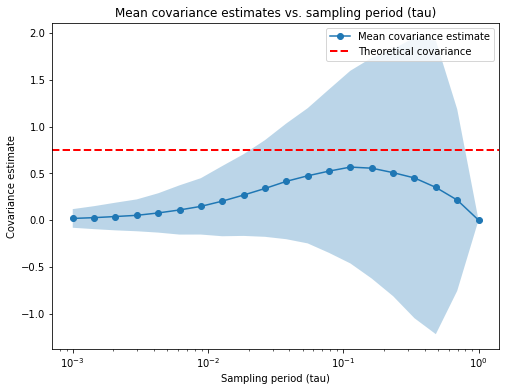

In [9]:
simulation(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho)

This plot illustrates the relationship between the sampling period 
and the mean covariance estimates. For low sampling periods, it highlights 
the Epps effect, as correlations between assets tend to diminish : actually, 
the price doesn't update that often because we used small intensity values 
for the two Poisson processes describing the observation times of the 
processes. The blue line represents mean covariance estimates, showing an 
initial increase with sampling period, peaking, and then declining. The 
shaded blue area indicates the confidence interval, widening at larger 
sampling periods, as a proof of increased uncertainty. In the end, the 
confidence interval decreases abruptly, probably due to a reduced noise 
for the largest values of $\tau$ or a smoothing effect as short-term 
fluctuations are reduced. This visualization underscores the trade-off 
between capturing sufficient data and maintaining estimation accuracy, 
with intermediate sampling periods providing estimates closest to the 
theoretical value, emphasizing the importance of selecting an appropriate 
sampling period. Indeed, we choose the sampling period large enough to 
capture data but small enough to have a correct estimate of the covariance. 

In [ ]:
def simulation_multiple(T, n_paths, tau_values, mu_1, mu_2, sigma_1, sigma_2, rho):
    dt = 0.0005
    time_grid = numpy.arange(0, T+dt, dt)
    sampling_grids = {}
    for tau in tau_values:
        sampling_grids[tau] = numpy.arange(0, T + tau, tau)
    n_steps = len(time_grid)

    Z_1 = numpy.random.normal(0,1,(n_paths, n_steps))
    Z_2 = numpy.random.normal(0,1,(n_paths, n_steps))

    dW_1 = numpy.sqrt(dt) * Z_1
    dW_2 = numpy.sqrt(dt) * (rho * Z_1 + numpy.sqrt(1-rho**2) * Z_2)

    W_1 = numpy.cumsum(dW_1, axis=1)
    W_2 = numpy.cumsum(dW_2, axis=1)

    p_1_full = sigma_1 * W_1
    p_2_full = sigma_2 * W_2
    cov_estimates = {tau: [] for tau in tau_values}

    for i in tqdm.tqdm(range(n_paths)):

        trade_times_1 = simulate_trade_times(mu_1, T)
        trade_times_2 = simulate_trade_times(mu_2, T)

        trade_prices_1 = get_trade_prices(time_grid, p_1_full[i,:], trade_times_1)
        trade_prices_2 = get_trade_prices(time_grid, p_2_full[i,:], trade_times_2)

        for tau in tau_values:

            sampling_times = sampling_grids[tau]

            sync_prices_1 = synchronize_to_grid(trade_times_1, trade_prices_1, sampling_times)
            sync_prices_2 = synchronize_to_grid(trade_times_2, trade_prices_2, sampling_times)

            cov_est = compute_covariance_estimator(sync_prices_1, sync_prices_2)
            cov_estimates[tau].append(cov_est)
            
    theoretical_cov = rho * sigma_1 * sigma_2 * T
    mean_cov = []
    std_cov = []
    for tau in tau_values:
        mean_cov.append(numpy.nanmean(cov_estimates[tau]))
        std_cov.append(numpy.nanstd(cov_estimates[tau]))

    mean_cov = numpy.array(mean_cov)
    std_cov = numpy.array(std_cov)
    return mean_cov, std_cov, theoretical_cov

In [ ]:
def plot_multiple_simulations():
    mu_1_values = numpy.linspace(50, 1000, 10)
    mu_2_values = numpy.linspace(60, 1000, 10)
    fig, ax = plt.subplots(5, 2, figsize=(24, 32))
    for i in range(len(mu_1_values)):
        mean_cov, std_cov, theoretical_cov = simulation_multiple(T, n_paths, tau_values, mu_1_values[i], mu_2_values[i], sigma_1, sigma_2, rho)
        ax[i//2, i%2].plot(tau_values, mean_cov, label='Mean covariance estimate', marker='o')
        ax[i//2, i%2].fill_between(tau_values, mean_cov - 2*std_cov, mean_cov + 2*std_cov, alpha=0.3)
        ax[i//2, i%2].axhline(theoretical_cov, color='red', linestyle='dashed', linewidth=2, label='Theoretical covariance')
        ax[i//2, i%2].set_xscale('log') 
        ax[i//2, i%2].set_xlabel("Sampling period (tau)")
        ax[i//2, i%2].set_ylabel("Covariance estimate")
        ax[i//2, i%2].set_title(f"Mean covariance estimates for $\mu_1$ = {mu_1_values[i]:.4f} and $\mu_2$ = {mu_2_values[i]:.4f} vs. sampling period (tau)")
    plt.legend()
    plt.show()

100%|██████████| 2000/2000 [07:14<00:00,  4.60it/s]


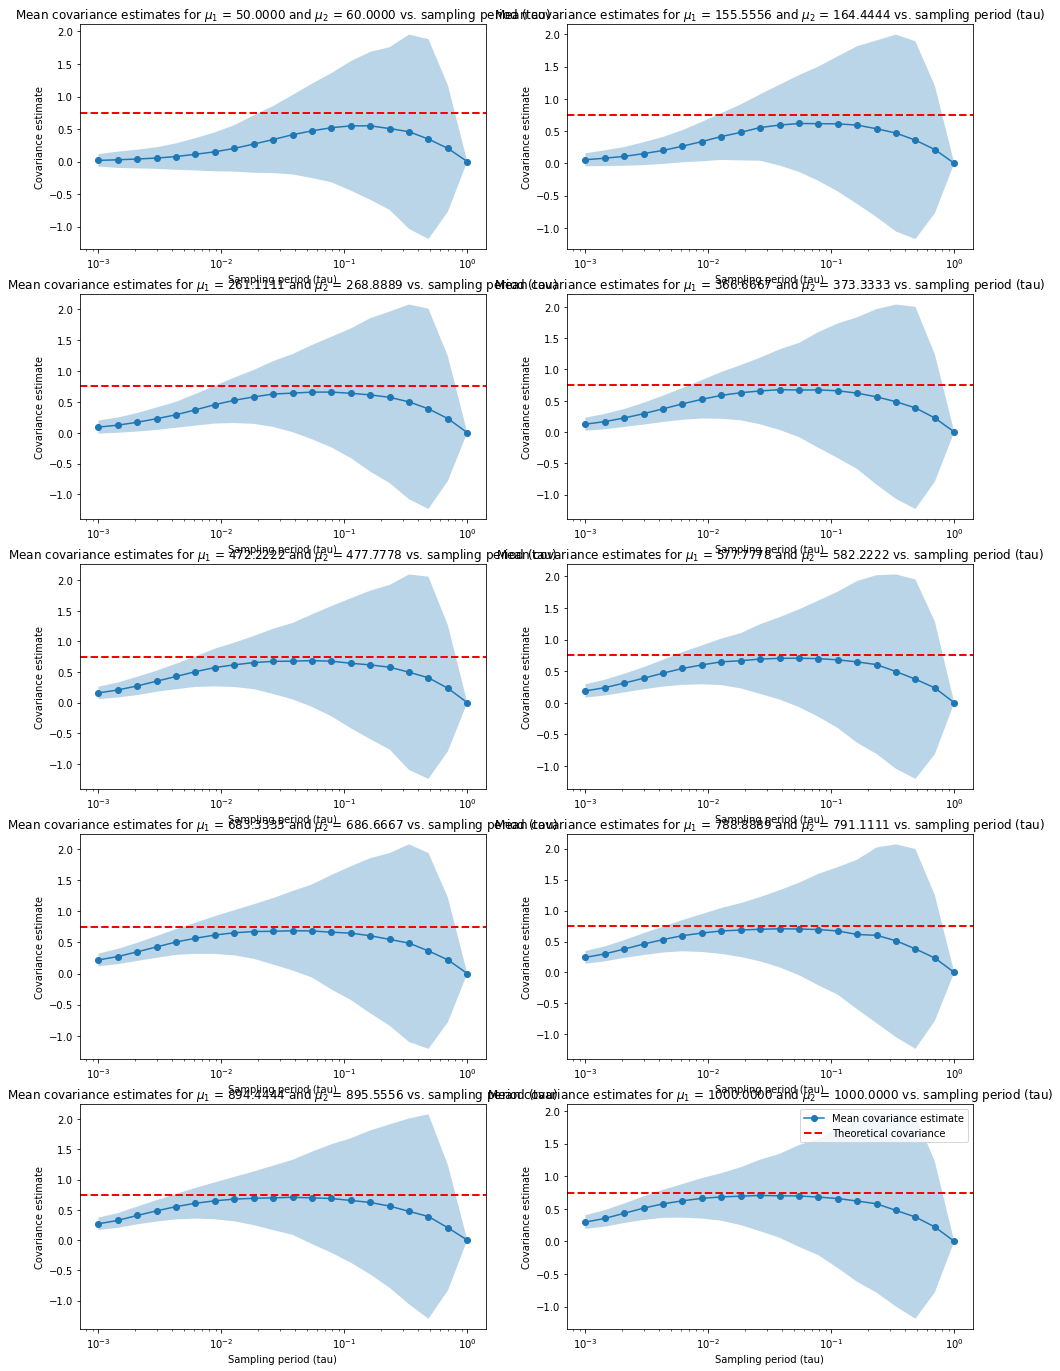

In [12]:
plot_multiple_simulations()

The series of plots illustrate the impact of increasing intensities 
of Poisson processes on mean covariance estimates across various 
sampling periods. As the intensities increase, the mean covariance 
estimates rises, particularly at intermediate sampling periods (for 
which it reaches its maximum). It reflects stronger correlations 
captured by higher event intensities. The confidence intervals widen 
with increasing sampling periods, as in the previous plot, indicating 
greater uncertainty, but tend to narrow at the highest sampling periods, 
suggesting stabilization in estimates. Again is highlighted the balance 
between capturing sufficient data and maintaining estimation accuracy. 
Overall, higher Poisson intensities enhance the covariance estimates, 
reflecting more pronounced interactions between the processes and slowly 
shifts the sampling period for which the maximum is reached to the left 
(smaller sampling periods). Indeed, higher intensities mean more trades captured
and therefore a smaller sampling period required. 

Question 3 : **Empirical intensities and LOB features.** The 
scientific literature on LOB suggests that intensities of order 
flows depend on observed LOB features. We will discuss this later in the course.
On your dataset, compute empirical intensities of trades as a function, 
for example, of the (rescaled) observed queue size or of the observed spread.
Comment on your findings.

In [ ]:
# Step 1: Load all files in the directory
data_path = "Data/SG/"
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
df_list = []
for file in file_list:
    df = pd.read_csv(data_path + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

filename_df = pd.concat(df_list, ignore_index=True)
filename_df['ets'] = pd.to_datetime(filename_df['ets'])
filename_df.head()

In [ ]:
filename_df['spread'] = filename_df['ap0'] - filename_df['bp0']

# We compute the total queue size: sum of best bid and best ask quantities
filename_df['queue_size'] = filename_df['bq0'] + filename_df['aq0']
mean_queue = filename_df['queue_size'].mean()
filename_df['rescaled_queue'] = numpy.log(1+filename_df['queue_size'] / mean_queue)

In [ ]:
def estimate_lambda_event_based(ordinal_df, negative_sample_ratio=1.0, features=['spread', 'rescaled_queue']):

    df = ordinal_df.copy()
    df['ets'] = pd.to_datetime(df['ets'])
    
    trades_df = df[df['etype'] == 'T'].copy()
    non_trades_df = df[df['etype'] != 'T'].copy()
    
    X_trades = trades_df[features]
    y_trades = numpy.ones(len(X_trades))
    
    n_neg = int(len(X_trades) * negative_sample_ratio)
    X_neg = non_trades_df[features].sample(n=n_neg, random_state=42)
    y_neg = numpy.zeros(len(X_neg))
    
    X_full = pd.concat([X_trades, X_neg], ignore_index=True)
    y_full = numpy.concatenate([y_trades, y_neg])
    
    # We add a constant term for the intercept
    X_with_const = statsmodels.api.add_constant(X_full)    
    # We fit a Poisson law
    model = statsmodels.api.GLM(y_full, X_with_const, family=statsmodels.api.families.Poisson()).fit()
    
    # Predict intensity
    X_full['lambda_hat'] = model.predict(X_with_const)
    X_full['y'] = y_full
    
    return X_full, model

In [ ]:
X_lambda, fitted_model = estimate_lambda_event_based(filename_df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_lambda['spread'], X_lambda['lambda_hat'], alpha=0.4)
plt.xlabel('Spread')
plt.ylabel('Intensity')
plt.title('Estimated Intensity vs. Spread')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X_lambda['rescaled_queue'], X_lambda['lambda_hat'], alpha=0.4)
plt.xlabel('Rescaled Queue Size')
plt.ylabel('Intensity')
plt.title('Estimated Intensity vs. Rescaled Queue Size')
plt.grid(True)

plt.tight_layout()
plt.show()

The plots illustrate the relationship between estimated intensity and 
two different metrics: spread and rescaled queue size. On the left, the 
scatter plot shows a clear inverse relationship between estimated intensity 
and spread, where higher spread values correspond to lower intensity 
estimates. It suggests that as market liquidity decreases (spread increases), 
the intensity of trading activity diminishes. On the right, the plot 
depicts a positive correlation between estimated intensity and rescaled 
queue size. This indicates that larger queue sizes,  often signifying 
greater market depth and liquidity, are mainly associated with higher 
trading intensities. 

In [ ]:
mean_rescaled_queue = X_lambda['rescaled_queue'].mean()
spread_grid = numpy.linspace(0, 150, 100)
df_plot_spread = pd.DataFrame({'const': 1.0, 'spread': spread_grid, 'rescaled_queue': mean_rescaled_queue})
pred_spread = fitted_model.get_prediction(df_plot_spread).summary_frame(alpha=0.05)
predicted_intensity_spread = pred_spread['mean']
lower_spread = pred_spread['mean_ci_lower']
upper_spread = pred_spread['mean_ci_upper']

mean_spread = X_lambda['spread'].mean()
rescaled_queue_grid = numpy.linspace(X_lambda['rescaled_queue'].min(), X_lambda['rescaled_queue'].max(), 100)
df_plot_queue = pd.DataFrame({'const': 1.0, 'spread': mean_spread, 'rescaled_queue': rescaled_queue_grid})
pred_queue = fitted_model.get_prediction(df_plot_queue).summary_frame(alpha=0.05)
predicted_intensity_queue = pred_queue['mean']
lower_queue = pred_queue['mean_ci_lower']
upper_queue = pred_queue['mean_ci_upper']

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(spread_grid, predicted_intensity_spread)
ax[0].fill_between(spread_grid, lower_spread, upper_spread, alpha=0.3)
ax[0].set_xlabel('Spread')
ax[0].set_ylabel('Intensity')
ax[0].set_title('Partial Effect of Spread\n(holding rescaled_queue at mean)')
ax[0].grid(True)

ax[1].plot(rescaled_queue_grid, predicted_intensity_queue)
ax[1].fill_between(rescaled_queue_grid, lower_queue, upper_queue, alpha=0.3)
ax[1].set_xlabel('Rescaled Queue')
ax[1].set_ylabel('Intensity')
ax[1].set_title('Partial Effect of Rescaled Queue\n(holding spread at mean)')
ax[1].grid(True)
plt.tight_layout()
plt.show()

Using a Poisson regression that labels trades as 1 and non‐trades as 0, we 
estimated the trade intensity : $\lambda^*(t) = f(spread(t),queue(t))$. 
The results show that bigger spreads imply lower intensity, while larger 
queue sizes are associated with a higher intensity. These findings are mostly 
intuitive : a larger spread often reduces trading by raising implicit 
transaction costs, whereas a thicker order book can signal deeper liquidity
and therefore encourage more frequent trades.